# Analyze red noise in one pulsar

In [38]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

from PTA import PTA
from likelihood import get_likelihood_obj
from samples import Samples

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# make PTA detector and model
pta = PTA(Np=1,  # number of pulsars
          Tspan_yr=15.,  # observation time span
          Nf=30,  # number of frequency bins to inject / model
          model_wn=True,  # model white noise (EFAC)
          model_rn=True,  # model intrinsic pulsar red noise
          model_gwb=False,  # model gravitational wave background
          model_cw=False,  # model continuous wave
          efacs_inj=jnp.array([1.0]),  # injected EFAC value
          rn_inj=jnp.array([-13.4, 3.2]),  # injected power law parameters
          seed=0,  # random seed for simulation
          )

# likelihood object
l = get_likelihood_obj(pta)

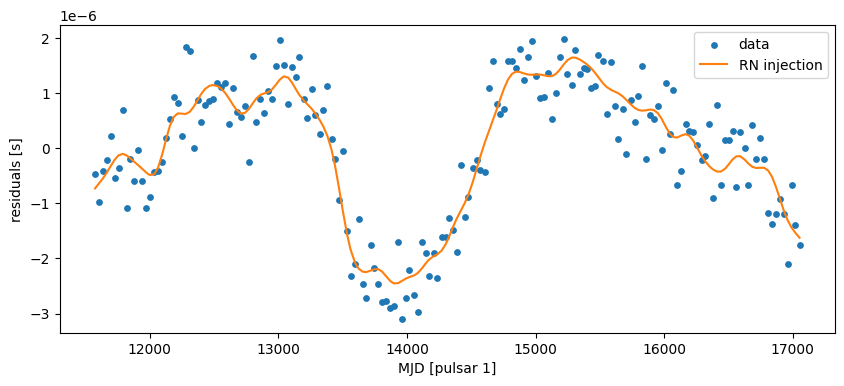

In [16]:
# plot data and injected signals
psr_ndx = 0
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.residuals[psr_ndx], color='C0', s=15, label='data')
rn_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
plt.plot(pta.MJDs[psr_ndx], rn_residuals_inj, color='C1', label='RN injection')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [17]:
# posterior density
@jit
def lnpost(x):

    # unpack parameters
    efacs = x[pta.efac_ndxs]
    rn_hypers = x[pta.rn_ndxs]
    a = x[pta.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    lnprior_val += l.a_lnprior_rn(rn_hypers, a)

    # likelihood
    lnlike_val = l.lnlike(efacs, a)

    return lnprior_val + lnlike_val


vectorized_lnpost = jit(vmap(lnpost))

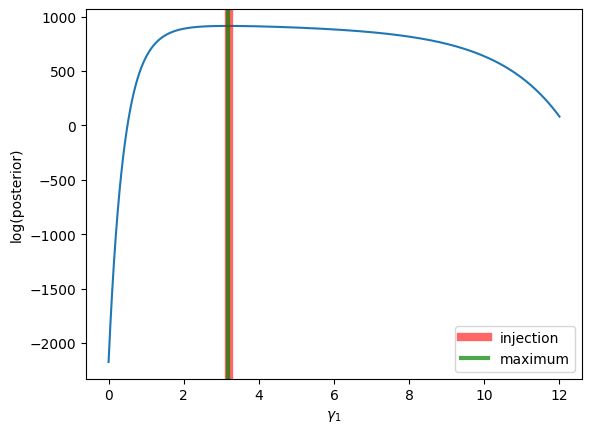

In [ ]:
# plot cross-section of posterior
# other parameters evaluated at injected values
param_ndx = 2
num_evals = 1000
param_vals = jnp.linspace(pta.x_mins[param_ndx], pta.x_maxs[param_ndx], num_evals)
params = jnp.tile(pta.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(pta.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [ ]:
# transform standard normal draw Fourier coefficients
# to multivariate normal conditioned on hyper-parameters
@jit
def transform_a(rn_hypers, a_standard):
    phi = jnp.zeros((pta.Na, pta.Np, pta.Np))
    phi = phi.at[:, jnp.arange(pta.Np), jnp.arange(pta.Np)].set(pta.vectorized_get_rho_diag(rn_hypers.reshape((pta.Np, 2))).T)
    Lc = vmap(lambda x: jsl.cholesky(x, lower=True))(phi)
    a_transformed = vmap(lambda L, x: L @ x)(Lc, a_standard.reshape((pta.Np, pta.Na)).T).T.flatten()
    return a_transformed

In [21]:
# kernel
def sampling_model():
    # uniform prior on hyper-parameters
    efacs = numpyro.sample('efacs', dist.Uniform(pta.efac_mins, pta.efac_maxs))
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta.rn_mins, pta.rn_maxs))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta.Na_PTA]))
    a_transformed = transform_a(rn_hypers, a_standard)
    a = numpyro.deterministic('a', a_transformed)

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike(efacs, a))

In [22]:
# sample with NumPyro NUTS
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(5e5))
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 510000/510000 [04:05<00:00, 2079.38it/s, 31 steps of size 1.81e-01. acc. prob=0.86]


In [33]:
# convert samples dictionary into numpy array
samples_arr = np.concatenate((samples_dict['efacs'],
                              samples_dict['rn_hypers'],
                              samples_dict['a'],
                              ), axis=1)

# make samples object for post-processing
samples = Samples(samples_arr=samples_arr,
                  labels=pta.x_labels,
                  x_inj=pta.x_inj,
                  lnpost_func=lnpost,
                  jax=True)

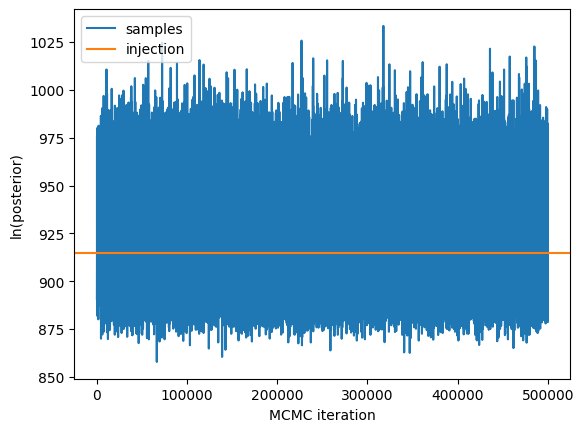

In [34]:
# plot posterior values over MCMC samples
samples.plt_posterior_vals(legend=True)

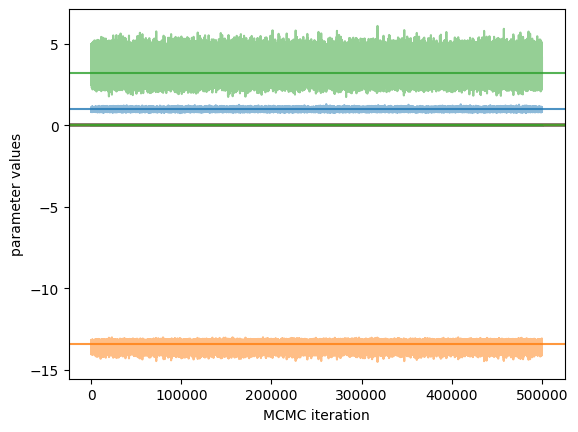

In [35]:
# plot parameter values over MCMC samples
samples.trace_plt(legend=False)

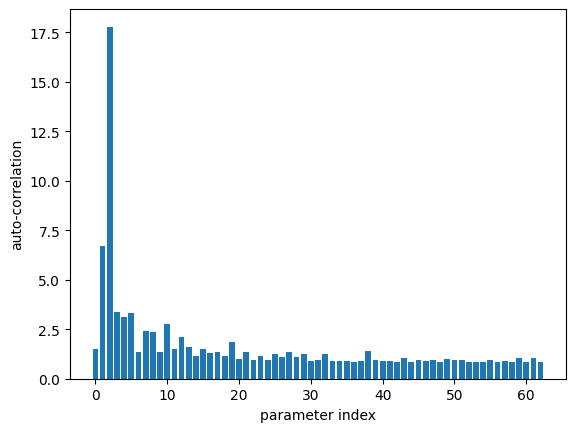

In [36]:
# plot auto-correlation length of parameters
samples.plt_auto_corr()

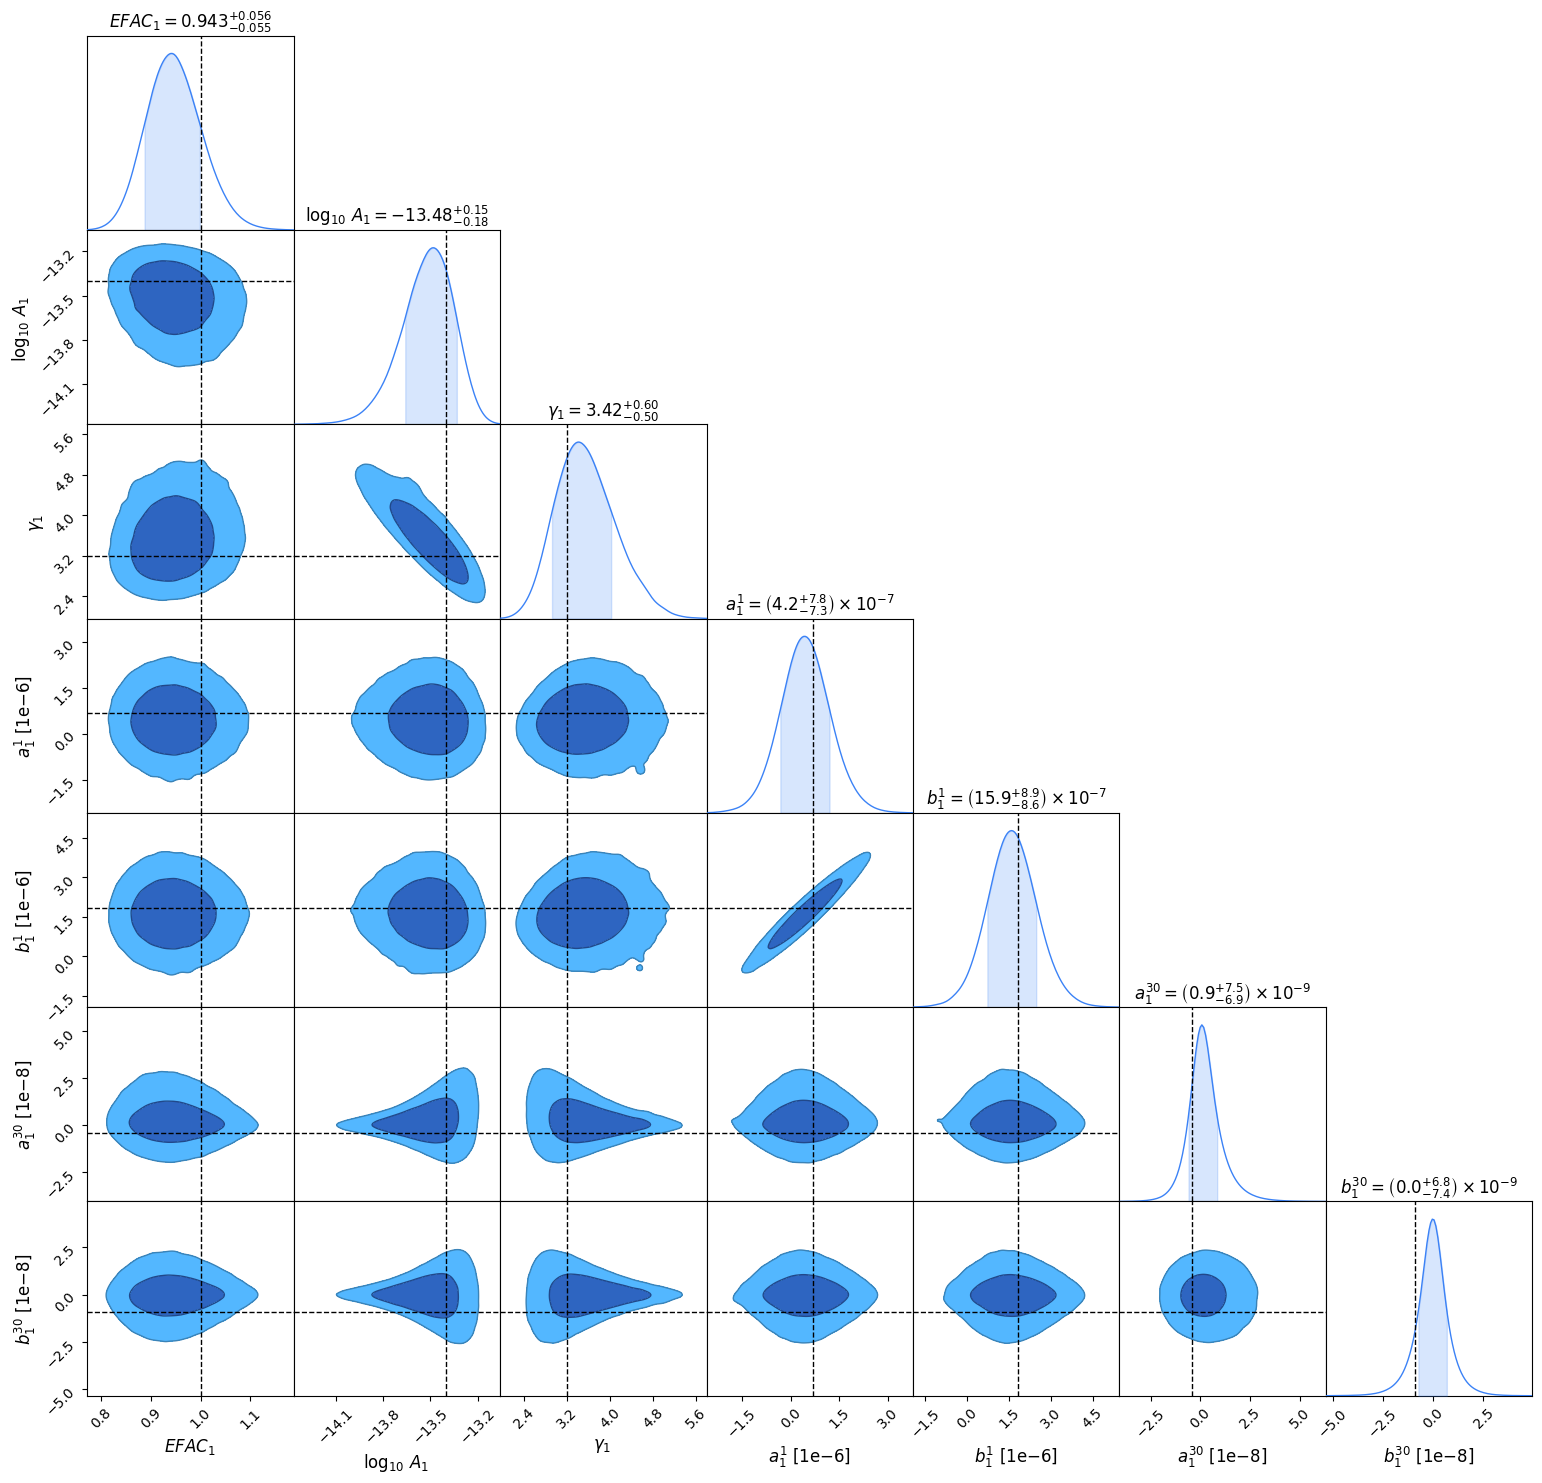

In [40]:
# indices of parameters to plot
ndxs = np.concatenate((pta.efac_ndxs,
                       pta.rn_ndxs,
                       pta.a_ndxs[:2],
                       pta.a_ndxs[-2:]))
# corner plot
samples.corner_plt(param_ndxs=ndxs, thin=1, color='blue')

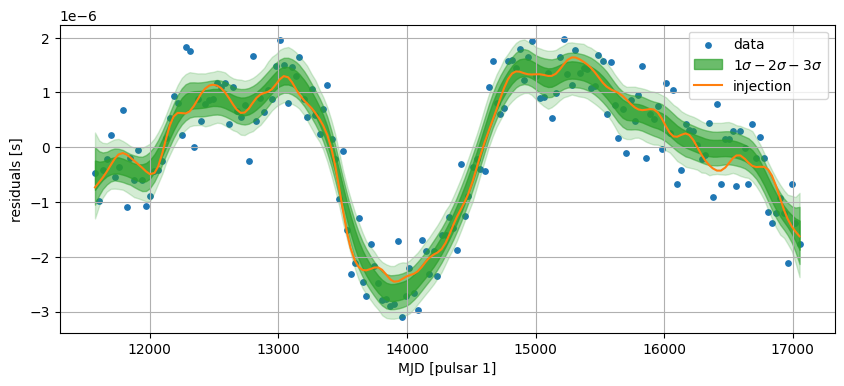

In [30]:
# Bayesogram
psr_ndx = 0
fair_draw_ndxs = np.random.choice(samples_arr.shape[0], (10_000,))

# percentile layers for plotting densities of samples
percentile_layers = [0.15, 2.5, 16.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')

rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples_arr[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                           for ndx in fair_draw_ndxs])
for percentile, alpha in zip(percentile_layers, alphas):
    if percentile != percentile_layers[-1]:
        plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='C2', alpha=alpha)
    else:
        plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='C2', alpha=alpha, label=r'$1\sigma-2\sigma-3\sigma$')
rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ rn_gwb_residuals_inj, color='C1', label='injection')

plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()